####**Institución Universitaria Pascual Bravo**
####Curso: Reconocimiento de patrones 2024-1

####Docente: Juan Carlos Briñez de León
####Descriptores de Tamura

##0. Datos de trabajo
[Clic aquí](https://data.caltech.edu/records/mzrjq-6wc02)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Crear una lista de todas las categorías (nombres de carpetas)
import os
from PIL import Image
import numpy as np
from google.colab import output
import matplotlib.pyplot as plt
import time


# Ruta al directorio donde deseas extraer el conjunto de datos
extracted_dir = '/content/drive/MyDrive/Semestre 8/ReconocimientoDePatrones/DTamura/Datos'

extracted_dir = os.path.join(extracted_dir, '101_ObjectCategories/')
categories = os.listdir(extracted_dir)

# Crear diccionario para mapear etiquetas a índices
label_to_index = {category: i for i, category in enumerate(categories)}

# Inicializar listas para imágenes y etiquetas
images = []
labels = []

# Recorrer todas las categorías
for category in categories:
    category_dir = os.path.join(extracted_dir, category)
    for filename in os.listdir(category_dir):
        image_path = os.path.join(category_dir, filename)
        image = Image.open(image_path)
        #plt.imshow(image,vmin=0,vmax=255)
        #plt.show()
        #time.sleep(0.5)
        images.append(np.resize(np.array(image),[350,350,3])) #Cambio de tamaño
        labels.append(label_to_index[category]) #
        output.clear()

# Convierte las listas en matrices numpy
images = np.array(images)
labels = np.array(labels)

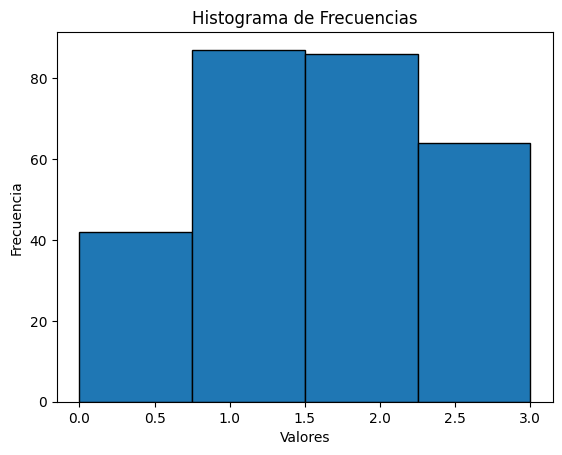

In [ ]:
# Crear el histograma
plt.hist(labels, bins=4, edgecolor='black')
plt.title('Histograma de Frecuencias')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.show()

#3. Ejercicio

A partir del dataset del Caltech, escoger 4 categorías y montar un ejercicio de clasificación utilizando los descriptores de textura por co-ocurrencia.

Extracción de características

In [5]:
##Extracción de características
import cv2
from google.colab import output
import numpy as np
from skimage.feature import graycoprops
from skimage.feature import graycomatrix as Co_ocurrencia

X = np.zeros((len(images),12)) # Vector de características de CoOcurrencia
Y = np.zeros((len(images),1)) # Vector de etiquetas, aunque ya se tiene, le pongo otro nombre

for k in range(len(images)):

  Y[k] = labels[k]

  #Preprocesamiento
  Imgr = cv2.cvtColor(images[k], cv2.COLOR_BGR2GRAY)

  # Calcular la matriz de coocurrencia
  #glcm = Co_ocurrencia(image, [distance], [Angle], levels=256, symmetric=True, normed=True) #normed=True el borde es el final de la imagen
  glcm = Co_ocurrencia(Imgr, [1,2,3,4,5,6,7,8,9,10], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
  max_prob = np.max(glcm)

  # Almacenando resultados
  X[k,0] = np.mean(graycoprops(glcm, 'contrast'))
  X[k,1] = np.mean(graycoprops(glcm, 'dissimilarity'))
  X[k,2] = np.mean(graycoprops(glcm, 'homogeneity'))
  X[k,3] = np.mean(graycoprops(glcm, 'ASM'))
  X[k,4] = np.mean(graycoprops(glcm, 'energy'))
  X[k,5] = np.mean(graycoprops(glcm, 'correlation'))
  X[k,6] = np.std(glcm) #rugosity
  X[k,7:11] = np.argwhere(glcm == max_prob)[0] #directionality

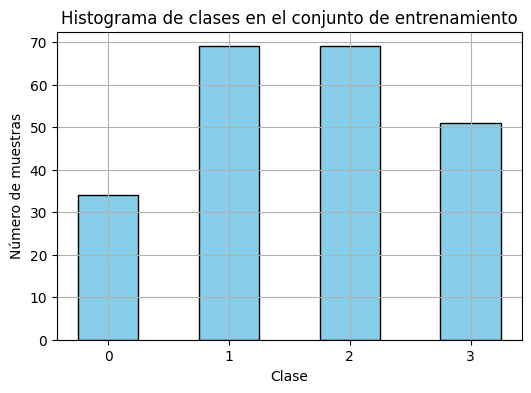

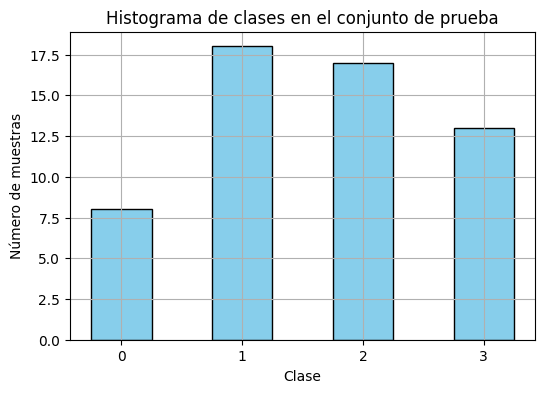

In [6]:
#Ojo, modificación para dividir los datos garantizando el balanceo de clases
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

Indices = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in Indices.split(X, Y):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index]

scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Dibujar el histograma del vector test de salida
hist_train, bins = np.histogram(Y_train, bins=[0,1,2,3,4])
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist_train, width=0.5, color='skyblue', edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Histograma de clases en el conjunto de entrenamiento')
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()


# Dibujar el histograma del vector test de salida
hist_test, bins = np.histogram(Y_test, bins=[0,1,2,3,4])
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist_test, width=0.5, color='skyblue', edgecolor='black')
plt.xlabel('Clase')
plt.ylabel('Número de muestras')
plt.title('Histograma de clases en el conjunto de prueba')
plt.xticks(bins[:-1])
plt.grid(True)
plt.show()

In [17]:
#Implementando un clasificador por comparación (KNN)
from sklearn.neighbors import KNeighborsClassifier as KNN

# Inicializar el clasificador KNN
Modelo_knn = KNN(n_neighbors=4)

# Entrenar el clasificador KNN con el conjunto de entrenamiento
Modelo_knn.fit(X_train_normalized, Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(n_neighbors=4)

In [18]:
#Métricas de evaluación
from sklearn.metrics import accuracy_score
Y_pred = Modelo_knn.predict(X_test_normalized)

# Calcular la precisión del modelo
accuracy = accuracy_score(Y_test, Y_pred)
print("Precisión del modelo KNN:", accuracy)

Precisión del modelo KNN: 0.5535714285714286


Evaluando el desempeño

Precisión del modelo KNN: 0.55




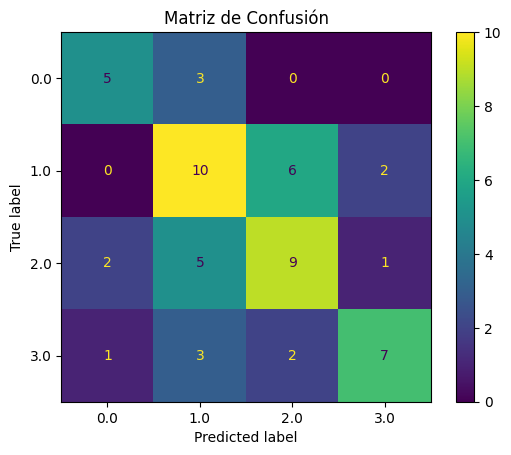


Classification Report:

              precision    recall  f1-score   support

         0.0       0.62      0.62      0.62         8
         1.0       0.48      0.56      0.51        18
         2.0       0.53      0.53      0.53        17
         3.0       0.70      0.54      0.61        13

    accuracy                           0.55        56
   macro avg       0.58      0.56      0.57        56
weighted avg       0.57      0.55      0.56        56




In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import accuracy_score

# Calcular la precisión del modelo
Y_pred = Modelo_knn.predict(X_test_normalized)
accuracy = accuracy_score(Y_test, Y_pred)

# Matriz
cm = confusion_matrix(Y_test, Y_pred)
report = classification_report(Y_test, Y_pred)

# Mostrar resultados
print(f"Precisión del modelo KNN: {accuracy:.2f}\n\n==================\n")

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Modelo_knn.classes_)
disp.plot()
# disp.plot(cmap=plt.cm.Purples)
plt.title('Matriz de Confusión')
plt.show()
print(f'==================\n\nClassification Report:\n\n{report}\n\n==================')